# The Effects of Shrinkage Methods on Physician Prediction 
## PSTAT 126 – Linear Regression
### Sam Sheridan

## Shrinkage Methods

The overuse of predictors in a regression model may lead to a variety of problems. Prediction performance can slump and explanations can be difficult due to collinearity. Ridge and Lasso regressions alter the traditional ordinary least squares estimators by adding a penalty to a slope. Practically speaking models where a small change in a predictor leads to a larger change in the response are penalized. These shrinkage methods are a means to improve prediction accuracy and remove or diminish the effects of unnecessary predictors. 

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
%matplotlib inline

In [195]:
CDI = pd.read_csv('CDI.csv')

In [196]:
CDI = CDI.drop('Unnamed: 0', axis=1) #drop redundant column

In [197]:
CDI.head()

,County,State,LandArea,TotalPop,Pop18,Pop65,Physicians,Beds,Crimes,HSGrad,Bachelor,Poverty,Unemp,IncPerCap,PersonalInc,Region
0,Cook,IL,946,5105067,29.2,12.4,15153,21550,436936,73.4,22.8,11.1,7.2,21729,110928,2
1,Harris,TX,1729,2818199,31.3,7.1,7553,12449,253526,74.9,25.4,12.5,5.7,19517,55003,3
2,San_Diego,CA,4205,2498016,33.5,10.9,5905,6179,173821,81.9,25.3,8.1,6.1,19588,48931,4
3,Orange,CA,790,2410556,32.6,9.2,6062,6369,144524,81.2,27.8,5.2,4.8,24400,58818,4
4,Kings,NY,71,2300664,28.3,12.4,4861,8942,680966,63.7,16.6,19.5,9.5,16803,38658,1


In [198]:
CDI['County'] = CDI['County'].astype('category')
CDI['State'] = CDI['State'].astype('category')
CDI['Region'] = CDI['Region'].astype('category')
CDI['TotalPop'] = CDI['TotalPop'].apply(np.log) #scale to improve normality assumptions
CDI['Physicians'] = CDI['Physicians'].apply(np.log) #scale to improve normality assumptions

In [199]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Ordinary Least Squares Model
 
I've created the linear models from earlier in the project to compare the later models too. First, the data is split into the predictor and the response, then rows for the training and testing data are randomly selected. This provides a method to measure the model's performance using previously unseen data. 

Specifically, these models will be fitted. 

***Physicians ~ log(TotalPop) + LandArea + IncPerCap***

and

***Physicians ~ log(TotalPop) + Region***

In [200]:
#create dummy variables for the regions
dummies = pd.get_dummies(CDI['Region'], prefix="Region")
CDI = pd.concat([CDI, dummies], axis = 1)

In [201]:
X_lm1 = CDI[['TotalPop', 'IncPerCap', 'LandArea']]
X_lm2 = CDI[['TotalPop', 'Region_1', 'Region_2', 'Region_3', 'Region_4']]
y_lm = CDI['Physicians']

The data is split into training and testing samples to later check prediction accuracy 

In [202]:
#partition training and testing data
X_train_lm1, X_test_lm1, y_train_lm1, y_test_lm1 = train_test_split(X_lm1, y_lm, test_size=0.33, random_state=47)
X_train_lm2, X_test_lm2, y_train_lm2, y_test_lm2 = train_test_split(X_lm2, y_lm, test_size=0.33, random_state=47)

## Ordinary Least Squares Model 1

In [203]:
#fit the first linear model
lm1 = linear_model.LinearRegression(normalize=True) #normalized for better comparison with later models
lm1.fit(X_train_lm1, y_train_lm1)
r_square_lm1 = lm1.score(X_test_lm1, y_test_lm1)
lm1_MSE = mean_squared_error(y_test_lm1, lm1.predict(X_test_lm1))
print("The Mean Squared Error for the first general linear model is %.2f" % lm1_MSE)
print("The R^2 value for the test data applied to the first linear model is %.3f" % r_square_lm1)

The Mean Squared Error for the first general linear model is 0.20
The R^2 value for the test data applied to the first linear model is 0.848


## Ordinary least Squares Model 2

In [204]:
#fit the second linear model 
lm2 = linear_model.LinearRegression(normalize=True) #normalized for better comparison with later models
lm2.fit(X_train_lm2, y_train_lm2)
r_square_lm2 = lm2.score(X_test_lm2, y_test_lm2)
lm2_MSE = mean_squared_error(y_test_lm2, lm2.predict(X_test_lm2))
print("The Mean Squared Error for the second general linear model is %.2f" % lm2_MSE)
print("The R^2 value for the test data applied to the second linear model is %.3f" % r_square_lm2)

The Mean Squared Error for the second general linear model is 0.22
The R^2 value for the test data applied to the second linear model is 0.833


### New Model Data

In [205]:
X = CDI.drop(['Physicians', 'County', 'State', 'Region'], axis=1)
y = CDI['Physicians']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 47)

## Ridge Regression 

The ridge regression estimate chooses $\beta$ to minimize $(y - X\beta)^{T}(y - X\beta) + \lambda\sum_j\beta_j^{2}$

The estimated $\beta$'s are given by $\hat{\beta} = (X^{T}X + \lambda I)^{-1}X^{T}y$

Ridge regression assumes that the regression coefficients should not be large — this is a valid assumption when many predictors are believed to have a similar effect on the response. Ridge regression provides biased estimators for the coefficients, however, it may lead to a decrease in variance and can thus lower mean square error. This is a classic example of bias-variance tradeoff.


The function **RidgeCV** fits a Ridge Regression model and chooses a penalty parameter from a range of values by comparing the fitted models of the various parameters through cross-validation; it chooses the model with the lower mean squared error. A range of values from 0.001 to 1 incrementing by 0.01 are tested. Due to the relatively small size of the dataset, tuning the hyperparameter from a large range of values through cross-validation is feasible. 

In [207]:
ridge = linear_model.RidgeCV(normalize = True, alphas = np.arange(0.0001, 1, .001))
ridge.fit(X_train, y_train)
ridge_R = ridge.score(X_test, y_test)
ridge_MSE = mean_squared_error(y_test, ridge.predict(X_test))

In [208]:
print("The Mean Squared Error for the ridge model is %.2f" % ridge_MSE)
print("The R^2 value for new data applied to the ridge model is %.3f" % ridge_R)
print("The penalty coefficient is %.4f" % ridge.alpha_)

The Mean Squared Error for the ridge model is 0.11
The R^2 value for new data applied to the ridge model is 0.917
The penalty coefficient is 0.0091


In [209]:
print(ridge.coef_)

[-3.93804709e-05  1.12084873e+00  2.30279548e-02  3.51210479e-02
  1.80106998e-04 -1.50671092e-06  1.94039926e-03  1.94408896e-02
  5.31492438e-02 -5.88849677e-02  5.19598510e-05 -2.75550390e-05
  8.06081171e-02 -8.05966328e-02 -7.38139237e-02  1.18100840e-01]


The ridge regression has greatly reduced the impact of many predictors, however it cannot fully removed any of them on its own. 

# Lasso Regression 

Lasso regression chooses $\hat{\beta}$ to minimize $(y-X\beta)^{T}(y-X\beta)$  subject to $\Sigma_{j=1}^{p}|\beta_j|\leq t$. This penalty may go to zero, removing predictors from the model and in effect grabbing the predictors you want with a metaphorical "lasso". Lasso regression is most applicable when the model is believed to be sparse; the response can be explained by a small number of predictors with the rest having no effect. **LassoLarsIC** chooses a hyperparameter, and thus model based on AIC or BIC. The larger the parameter the more predictors are removed. Information criterion is used over cross validation because cross validation maximizes prediction accuracy without accounting for model complexity. 

## Lasso Model Selection with AIC

In [210]:
lassoAIC = linear_model.LassoLarsIC(normalize=True, criterion = 'aic')
lassoAIC.fit(X_train, y_train)

LassoLarsIC(copy_X=True, criterion='aic', eps=2.220446049250313e-16,
            fit_intercept=True, max_iter=500, normalize=True, positive=False,
            precompute='auto', verbose=False)

In [211]:
print("The penalty coefficient choosen by AIC is: %f" % lassoAIC.alpha_)
print("The score of the AIC choosen model is: %f" % lassoAIC.score(X_test, y_test))
print("The MSE of the AIC model is %f" % mean_squared_error(y_test, lassoAIC.predict(X_test)))
print("The AIC model used %.f predictors" % len(np.where(lassoAIC.coef_ != 0)[0]))

The penalty coefficient choosen by AIC is: 0.000168
The score of the AIC choosen model is: 0.919086
The MSE of the AIC model is 0.108892
The AIC model used 14 predictors


### Predictors used in AIC model

In [212]:
s = ', '.join(X.iloc[:, np.where(lassoAIC.coef_ != 0)[0]].columns)
print(s)

LandArea, TotalPop, Pop18, Pop65, Beds, Crimes, Bachelor, Poverty, Unemp, IncPerCap, PersonalInc, Region_1, Region_2, Region_4


The AIC choosen model is accurate, but barely reduces dimensionality.

## Lasso Model Selection with BIC

In [213]:
lassoBIC = linear_model.LassoLarsIC(normalize=True, criterion = 'bic')
lassoBIC.fit(X_train, y_train)

LassoLarsIC(copy_X=True, criterion='bic', eps=2.220446049250313e-16,
            fit_intercept=True, max_iter=500, normalize=True, positive=False,
            precompute='auto', verbose=False)

In [214]:
print("The penalty coefficient choosen by BIC is: %f" % lassoBIC.alpha_)
print("The score of the BIC choosen model is: %f" % lassoBIC.score(X_test, y_test))
print("The MSE of the BIC model is %f" % mean_squared_error(y_test, lassoBIC.predict(X_test)))
print("The BIC model used %.f predictors" % len(np.where(lassoBIC.coef_ != 0)[0]))

The penalty coefficient choosen by BIC is: 0.005859
The score of the BIC choosen model is: 0.857615
The MSE of the BIC model is 0.191618
The BIC model used 3 predictors


### Predictors used in BIC model

In [215]:
print(' '.join(X.iloc[:, np.where(lassoBIC.coef_ != 0)[0]].columns))

TotalPop Beds Bachelor


Lasso Regression optimized with BIC reduced the number of predictors down to 3 while maintaining high accuracy. It had better predictions then the optimized OLS models from earlier in the report 

## Simplicity - Accuracy Tradeoff

### prediction accuracy can be given up for a lower dimensional model

In [216]:
predictors_dropped = []
a = np.arange(0.001, 0.1, 0.001)
accuracy = []

In [217]:
for i in range(len(a)):
    l = linear_model.Lasso(normalize=True, alpha=a[i])
    l.fit(X_train, y_train)
    accuracy.append(l.score(X_test, y_test))
    predictors_dropped.append(len(np.where(l.coef_ == 0)[0]))
    

[]

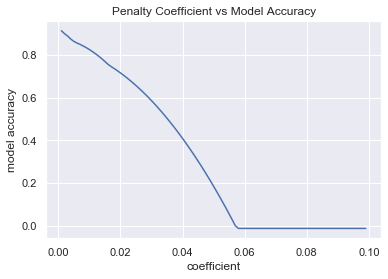

In [218]:
sns.set()
plt.plot(a, accuracy)
plt.title("Penalty Coefficient vs Model Accuracy")
plt.xlabel("coefficient")
plt.ylabel('model accuracy')
plt.plot()

The model is most accurate with the lowest given coefficient; if allowed the model would drop the penalty term and simply become the OLS model. 

[]

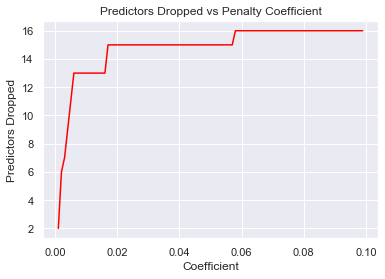

In [219]:
plt.plot(a, predictors_dropped, color='red')
plt.title("Predictors Dropped vs Penalty Coefficient")
plt.xlabel('Coefficient')
plt.ylabel('Predictors Dropped')
plt.plot()

As the penalty coefficient increases the prediction accuracy decreases, but the number of predictors dropped increases. This simplifies the model.

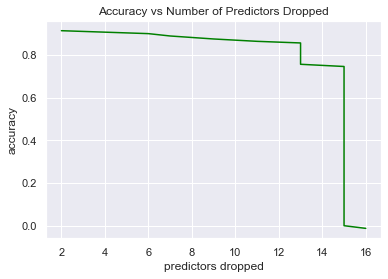

In [220]:
plt.plot(predictors_dropped, accuracy, color='green')
plt.title("Accuracy vs Number of Predictors Dropped")
plt.xlabel("predictors dropped")
plt.ylabel("accuracy")
plt.show()

A large number of predictors can be dropped without a significant decrease in prediction accuracy. A similarly accurate model can be produced with only 3 predictors, as shown in the BIC model.  

## Comparing The Models

The lasso regression with BIC criterion effectively reduced the size of the model while maintaining prediction accuracy. The lasso regression also out-performed the smaller OLS models from the initial project using the same number of predictors. Lasso Regression proved to be an effective shrinkage method on the data set. Ridge regression greatly penalized unnecessary predictors in the model but is unable to fully remove them. The predictors from the ridge regression with the smallest coefficients could be dropped to reduce dimensionality. 

While OLS models are generally more interpretable, the regularized regressions are often much better for prediction as they prevent overfitting and provide a means for choosing a smaller model. Lasso regressions are also far more effective on sparse models than OLS models.  

# Sparse Model Example 

To show the benefits of a lasso model the training data will be sampled to create sparse training data. There are 425 rows and 16 columns, so around 20 rows of the data will be used to train the OLS and a lasso model. In order to train the OLS model for comparison, there must be more than 16 rows; however, the lasso model will still work on an extremely sparse subset of the data with under 16 rows. The data will be radomy sampled multiple times to provide an average accuracy for the models 

In [221]:
lasso_R = []
ols_R = []
lasso_mse = []
ols_mse = []

In [222]:
for i in range(100):
    X_train_sparse, X_test_sparse, y_train_sparse, y_test_sparse = train_test_split(X, y, test_size = 0.95, random_state = i)
    sparse_lasso = linear_model.LassoLarsIC(normalize=True, criterion = 'bic', max_iter=8)
    sparse_lasso.fit(X_train_sparse, y_train_sparse)
    lasso_R.append(sparse_lasso.score(X_test_sparse, y_test_sparse))
    lasso_mse.append(mean_squared_error(y_test_sparse, sparse_lasso.predict(X_test_sparse)))
    
    sparse_ols = linear_model.LinearRegression(normalize=True)
    sparse_ols.fit(X_train_sparse, y_train_sparse)
    ols_R.append(sparse_ols.score(X_test_sparse, y_test_sparse))
    ols_mse.append(mean_squared_error(y_test_sparse, sparse_ols.predict(X_test_sparse)))
    
    

In [223]:
print("The average lasso model's R^2 is %.3f" % np.mean(lasso_R))
print("The average lasso model's MSE is %.3f" % np.mean(lasso_mse))
print("The average OLS model's R^2 is %.3f" % np.mean(ols_R))
print("The average OLS model's MSE is %.3f" % np.mean(ols_mse))

The average lasso model's R^2 is 0.620
The average lasso model's MSE is 0.469
The average OLS model's R^2 is -0.895
The average OLS model's MSE is 2.354


The lasso regression fully removes many of the predictors, while the OLS regression does not. The lasso regression is far more accurate in terms of prediction. 

## The Lasso model performs far better than OLS on sparse data sets
### This is shown in the following histograms

Note: because R^2 is computed on testing data, it can be negative and arbitrarily small to indicate a worse model. 

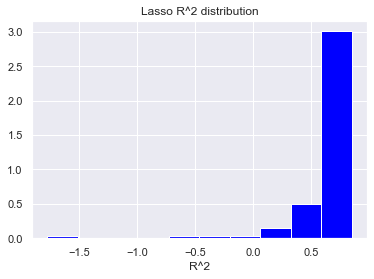

In [224]:
plt.hist(lasso_R, color='blue', density=True)
plt.title('Lasso R^2 distribution')
plt.xlabel('R^2')
plt.show()

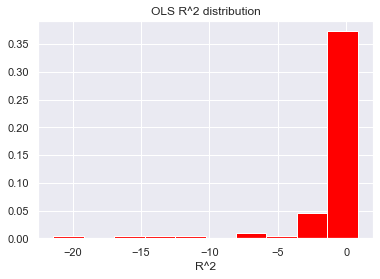

In [225]:
plt.hist(ols_R, color='red', density=True)
plt.title('OLS R^2 distribution')
plt.xlabel('R^2')
plt.show()

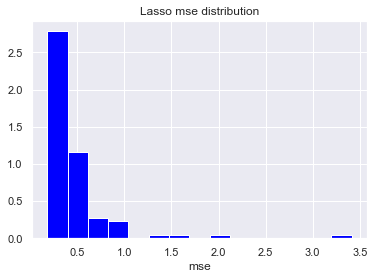

In [226]:
plt.hist(lasso_mse, color='blue', density=True, bins=15)
plt.title('Lasso mse distribution')
plt.xlabel('mse')
plt.show()

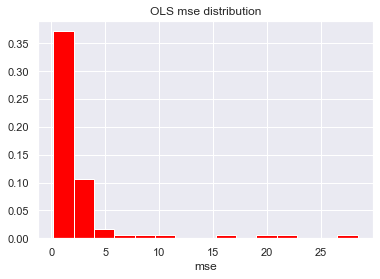

In [227]:
plt.hist(ols_mse, color='red', density=True, bins=15)
plt.title('OLS mse distribution')
plt.xlabel('mse')
plt.show()